In [16]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, random_split,DataLoader
from torch import nn
import torch.optim as optim

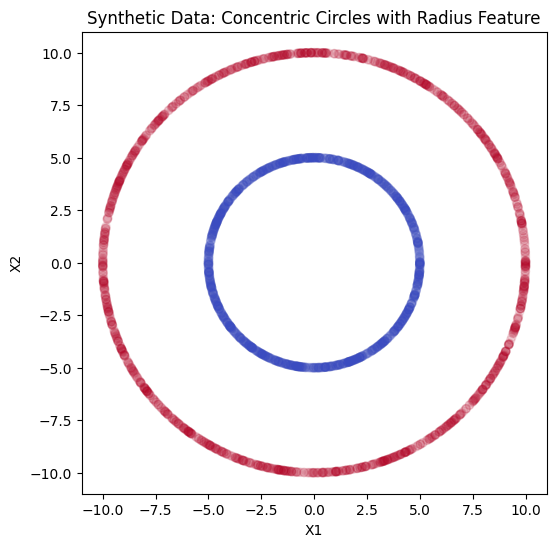

In [23]:


# Set the number of samples and radius of circles
num_samples = 3000
radius_inner = 5
radius_outer = 10

# Generate random angles for the circles
angles = torch.rand(num_samples) * 2 * torch.pi

# Split the dataset equally between the two classes
inner_samples = num_samples // 2
outer_samples = num_samples - inner_samples

# Generate inner circle (class 0)
x_inner = radius_inner * torch.cos(angles[:inner_samples])
y_inner = radius_inner * torch.sin(angles[:inner_samples])
data_inner = torch.stack((x_inner, y_inner), dim=1)
labels_inner = torch.zeros(inner_samples, dtype=torch.long)

# Generate outer circle (class 1)
x_outer = radius_outer * torch.cos(angles[:outer_samples])
y_outer = radius_outer * torch.sin(angles[:outer_samples])
data_outer = torch.stack((x_outer, y_outer), dim=1)
labels_outer = torch.ones(outer_samples, dtype=torch.long)

# Combine the inner and outer circle data
data = torch.cat((data_inner, data_outer), dim=0)
labels = torch.cat((labels_inner, labels_outer), dim=0)

# Calculate radius for each point
radius = torch.sqrt(data[:, 0]**2 + data[:, 1]**2)

# Add radius as the third column to the data
data_with_radius = torch.cat((data, radius.unsqueeze(1)), dim=1)

# Visualize the data with radius as an extra feature
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="coolwarm", alpha=0.1)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Synthetic Data: Concentric Circles with Radius Feature")
plt.show()



In [24]:
labels

tensor([0, 0, 0,  ..., 1, 1, 1])

In [28]:


# Combine data and labels into a single dataset
dataset = TensorDataset(data_with_radius, labels)

# Set the split ratio for train and test
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Separate data and labels for train and test sets
train_data = torch.stack([sample[0] for sample in train_dataset])
train_labels = torch.tensor([sample[1] for sample in train_dataset])

test_data = torch.stack([sample[0] for sample in test_dataset])
test_labels = torch.tensor([sample[1] for sample in test_dataset])

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")


Training set size: 2400
Testing set size: 600


In [29]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

torch.Size([2400, 3])
torch.Size([2400])
torch.Size([600, 3])
torch.Size([600])


In [41]:
train_data

tensor([[ 9.9248,  1.2245, 10.0000],
        [-8.4574,  5.3359, 10.0000],
        [ 4.9998, -0.0443,  5.0000],
        ...,
        [-3.7890, -3.2624,  5.0000],
        [-4.8613,  8.7389, 10.0000],
        [-6.6165, -7.4981, 10.0000]])

In [40]:
# class SimpleNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden1= nn.Linear(2,16)
#         self.hidden2= nn.Linear(16,16)
#         self.output= nn.Linear(16,2)
#         self.relu= nn.ReLU()
#         self.softmax= nn.Softmax(dim=1)
        
        
#     def forward(self,x):
#         x= self.relu(self.hidden1(x))
#         x= self.relu(self.hidden2(x))
#         x= self.softmax(self.output(x))
#         return x
    
# model= SimpleNN()

# print(model)

In [57]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input=nn.Linear(3,64)
        self.hidden1=nn.Linear(64,32)
        self.hidden2=nn.Linear(32,16)
        self.attention = nn.MultiheadAttention(embed_dim=16,num_heads=1,batch_first=True)
        self.output=nn.Linear(16,2)
        self.relu=nn.ReLU()
        self.softmax= nn.Softmax(dim=1)
    def forward(self,x):
        x=self.relu(self.input(x))
        x=self.relu(self.hidden1(x))
        x=self.relu(self.hidden2(x))
        
        x=x.unsqueeze(1)   
        x,_= self.attention(x,x,x)
        x=x.squeeze(1)
        
        x=self.softmax(self.output(x))
        return x

model = SimpleNN()
print(model)

SimpleNN(
  (input): Linear(in_features=3, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=16, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (output): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [58]:
model = SimpleNN()
loss_fn= nn.CrossEntropyLoss()
optimizor = optim.Adam(model.parameters(),lr=0.01)

In [59]:
batch_size=32
train_dataset=TensorDataset(train_data,train_labels)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)

In [60]:
epochs=20

for epoch in range(epochs):
    model.train()
    
    outputs = model(train_data)
    loss=loss_fn(outputs,train_labels)
    
    optimizor.zero_grad()
    loss.backward()
    optimizor.step()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 0.6941
Epoch [2/20], Loss: 0.6696
Epoch [3/20], Loss: 0.6781
Epoch [4/20], Loss: 0.6574
Epoch [5/20], Loss: 0.6551
Epoch [6/20], Loss: 0.6518
Epoch [7/20], Loss: 0.6410
Epoch [8/20], Loss: 0.6305
Epoch [9/20], Loss: 0.6254
Epoch [10/20], Loss: 0.6085
Epoch [11/20], Loss: 0.5933
Epoch [12/20], Loss: 0.5786
Epoch [13/20], Loss: 0.5542
Epoch [14/20], Loss: 0.5312
Epoch [15/20], Loss: 0.4939
Epoch [16/20], Loss: 0.4589
Epoch [17/20], Loss: 0.4315
Epoch [18/20], Loss: 0.3940
Epoch [19/20], Loss: 0.3618
Epoch [20/20], Loss: 0.3406


In [62]:
epochs =20
for epochs in range(epochs):
    model.train()
    total_loss=0.0
    
    for batch_data,batch_labels in train_loader:
        outputs = model(batch_data)
        loss = loss_fn(outputs,batch_labels)
        
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
        
        total_loss+=loss.item()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [20/0], Loss: 0.3138
Epoch [20/1], Loss: 0.3133
Epoch [20/2], Loss: 0.3133
Epoch [20/3], Loss: 0.3133
Epoch [20/4], Loss: 0.3133
Epoch [20/5], Loss: 0.3133
Epoch [20/6], Loss: 0.3133
Epoch [20/7], Loss: 0.3133
Epoch [20/8], Loss: 0.3133
Epoch [20/9], Loss: 0.3133
Epoch [20/10], Loss: 0.3133
Epoch [20/11], Loss: 0.3133
Epoch [20/12], Loss: 0.3133
Epoch [20/13], Loss: 0.3133
Epoch [20/14], Loss: 0.3133
Epoch [20/15], Loss: 0.3133
Epoch [20/16], Loss: 0.3133
Epoch [20/17], Loss: 0.3133
Epoch [20/18], Loss: 0.3133
Epoch [20/19], Loss: 0.3133


In [63]:
model.eval()
with torch.no_grad():
    test_outputs=model(test_data)
    _,predicted= torch.max(test_outputs,1)
    accuracy = (predicted==test_labels).float().mean().item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 100.00%
